In [1]:
import warnings
import os,sys
sys.path.append("./share")
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import warnings
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from SHVisualize import CSHVisualize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("./Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv",low_memory=False)

1.添加协议字段

2.去掉异常数据

In [3]:
def pre_process(x):
    mainCate = "Other"
    subCate = "Other"
    if x['frame.time'].find(":") <0 :
        return ["Error",None]
    if x['arp.hw.size'] > 0:
        return ["ARP","ARP"]
    if x['ip.src_host'] in ['0','0.0.0.0']:
        return ["Error",None]
    if x['icmp.seq_le'] > 0 or x['icmp.checksum'] > 0 :
        return ["ICMP","ICMP"]
    if x['udp.port'] > 0 and x['dns.qry.name'] != 0:
        return ["UDP","DNS"]
    if x['udp.port'] > 0:
        return ["UDP","UDP"]
    if (x['tcp.seq'] > 0 or x['tcp.checksum'] > 0) and (x['http.request.version'] != "0.0"):
        return ["TCP","HTTP"]
    if (x['tcp.seq'] > 0 or x['tcp.checksum'] > 0) and ( x['mqtt.ver'] != 0):
        return ["TCP","MQTT"]
    if (x['tcp.seq'] > 0 or x['tcp.checksum'] > 0) and (x['mbtcp.len'] > 0 ):
        return ["TCP","ModBus"]
    if x['tcp.seq'] > 0 or x['tcp.checksum'] > 0:
        return ["TCP","TCP"]
    if x['ip.dst_host'] in ['224.0.0.1','224.0.0.251','224.0.0.252']:
        return [mainCate,"Broadcast"]
    return [mainCate,subCate]
ds_temp = df.progress_apply(pre_process,axis=1)
df[['mainCate', 'subCate']] = pd.DataFrame(ds_temp.tolist())
#df = df[df['mainCate'] !="Other"]
#df = df[df['mainCate'] !="Error"]
#df = df.dropna()

  0%|          | 0/2219201 [00:00<?, ?it/s]

In [4]:
df[df['mainCate']=='Error']

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type,mainCate,subCate
692,2021 11:44:51.585106000,0.0.0.0,224.0.0.1,0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,Normal,Error,None
693,2021 11:44:51.587220000,0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,Normal,Error,None
694,2021 11:44:51.993461000,0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,Normal,Error,None
712,2021 11:44:52.990740000,0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,Normal,Error,None
761,2021 11:44:56.487014000,0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,Normal,Error,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102761,89.44.57.100,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP,Error,None
2102762,61.255.209.138,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP,Error,None
2102763,129.33.149.131,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP,Error,None
2102764,17.226.209.145,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP,Error,None


In [5]:
df_data = df[["Attack_label",'Attack_type','mainCate','subCate','frame.time']]
#df_data = df_data[df_data['Attack_label'] == 1]
df_data1 = df_data.groupby(["mainCate","subCate","Attack_type"]).count()['frame.time'].reset_index()
pie = CSHVisualize.get_sankey(df_data1,"攻击样本分布")
pie.load_javascript()

In [6]:
pie.render_notebook()

<Axes: >

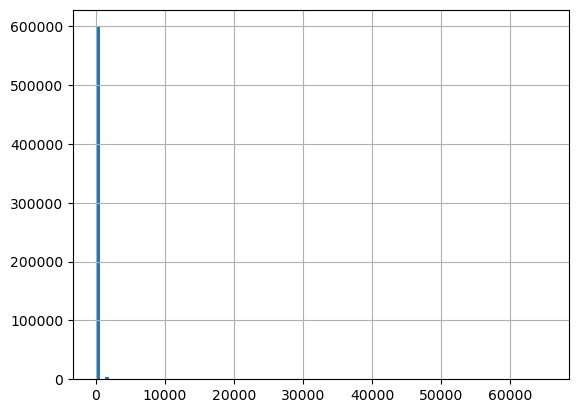

In [7]:
df_test = df[df['Attack_label']==1]
df_test['tcp.len'].hist(bins=100)

<Axes: >

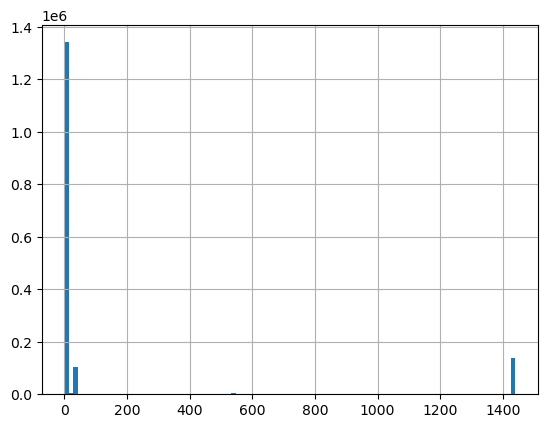

In [8]:
df_test = df[df['Attack_label']==0]
df_test['tcp.len'].hist(bins=100)